# HW 1. Рекап предыдущего года.

### Вариант 6.

### steam-video-games

Описание датасета:

Этот набор данных представляет собой список поведений пользователя со столбцами: user-id, game-title, behavior-name, value. Включенные поведения — «покупка» и «игра». Значение указывает на степень выполнения поведения — в случае «покупки» значение всегда равно 1, а в случае «игры» значение представляет собой количество часов, в течение которых пользователь играл в игру.

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix
)

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy


## Подготовка данных

In [2]:
# загрузка данных
path = kagglehub.dataset_download("tamber/steam-video-games")
file_path = os.path.join(path, 'steam-200k.csv')
df = pd.read_csv(file_path)

df


,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0
...,...,...,...,...,...
199994,128470551,Titan Souls,play,1.5,0
199995,128470551,Grand Theft Auto Vice City,purchase,1.0,0
199996,128470551,Grand Theft Auto Vice City,play,1.5,0
199997,128470551,RUSH,purchase,1.0,0


Добавим названия колонок из описания датасета. Последняя колонка показалась мне странной:

In [3]:
df['0'].describe()


count    199999.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: 0, dtype: float64

Она полностью нулевая, кроме того, не имеет описания на странице датасета. Уберем ее из данных

In [4]:
df.columns = ['user_id', 'game_title', 'behavior_name', 'value', 'unknown']
df.drop('unknown', axis=1, inplace=True)
df.head(5)


,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9


## 1-2. Анализ данных, моделирование и поиск связей

Проводя визуальный анализ, можно сразу сказать, что данных (признаков) немного. Рассмотрим их подробнее с целью генерации новых возможных признаков

In [5]:
print(f"Количество уникальных игр: {len(df['game_title'].unique())}")
print(f"Количество уникальных пользователей: {len(df['user_id'].unique())}")


Количество уникальных игр: 5155
Количество уникальных пользователей: 12393


Сначала рассмотрим на примере одного клиента

In [6]:
client_sample = df[df['user_id'] == 151603712]

print(f"Куплено игр пользователем: {len(client_sample[client_sample['behavior_name']  == 'purchase'])}")
print(f"Количество игр, в которые он играл: {len(client_sample[client_sample['behavior_name']  == 'play'])}")


Куплено игр пользователем: 39
Количество игр, в которые он играл: 26


То есть не всегда пользователь играет в игру, которую покупает.
Можно ли расценить, как будто пользователю "не понравилась" купленная игра?

Но при этом не всегда пользователь покупает игру, в которую он играет. Интересно, как это возможно.....

In [7]:
df[(df['user_id'] == 151603712) & (df['game_title'] == 'The Elder Scrolls V Skyrim')]


,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,play,273.0


Еще одно наблюдение - часть игр является "дополнениями" или "продолжениями". Например:

    The Elder Scrolls V Skyrim

и ее дополнения

    The Elder Scrolls V Skyrim - Dawnguard
    The Elder Scrolls V Skyrim - Dragonborn
    The Elder Scrolls V Skyrim - Hearthfire

или игра

    Left 4 Dead
    Left 4 Dead 2

In [8]:
df[(df['user_id'] == 151603712) & (df['game_title'].str.startswith('The Elder Scrolls V Skyrim'))]

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,play,273.0
62,151603712,The Elder Scrolls V Skyrim - Dawnguard,purchase,1.0
63,151603712,The Elder Scrolls V Skyrim - Dragonborn,purchase,1.0
64,151603712,The Elder Scrolls V Skyrim - Hearthfire,purchase,1.0


Получается, что пользователь покупает дополнения, но не играет в них, поскольку они являются частью основной игры, в которую идет трек часов. Это противоречит предыдущему предположению - если пользователь купил игру, она может ему "нравиться", в случае, если она является DLC другой игры

In [9]:
df[(df['user_id'] == 151603712) & (df['game_title'].str.startswith('Left 4 Dead'))]

,user_id,game_title,behavior_name,value
7,151603712,Left 4 Dead 2,purchase,1.0
8,151603712,Left 4 Dead 2,play,8.9
15,151603712,Left 4 Dead,purchase,1.0
16,151603712,Left 4 Dead,play,3.3


При этом следующая версия игры идет отдельным продуктом. Мы вернемся к этому позднее, но, кажется, обработка этих случаев может вызвать сложности.

---------

Построим графики и рассмотрим имеющиеся связи в данных.

### Данные в разрезе игр

1. Популярность по числу покупок

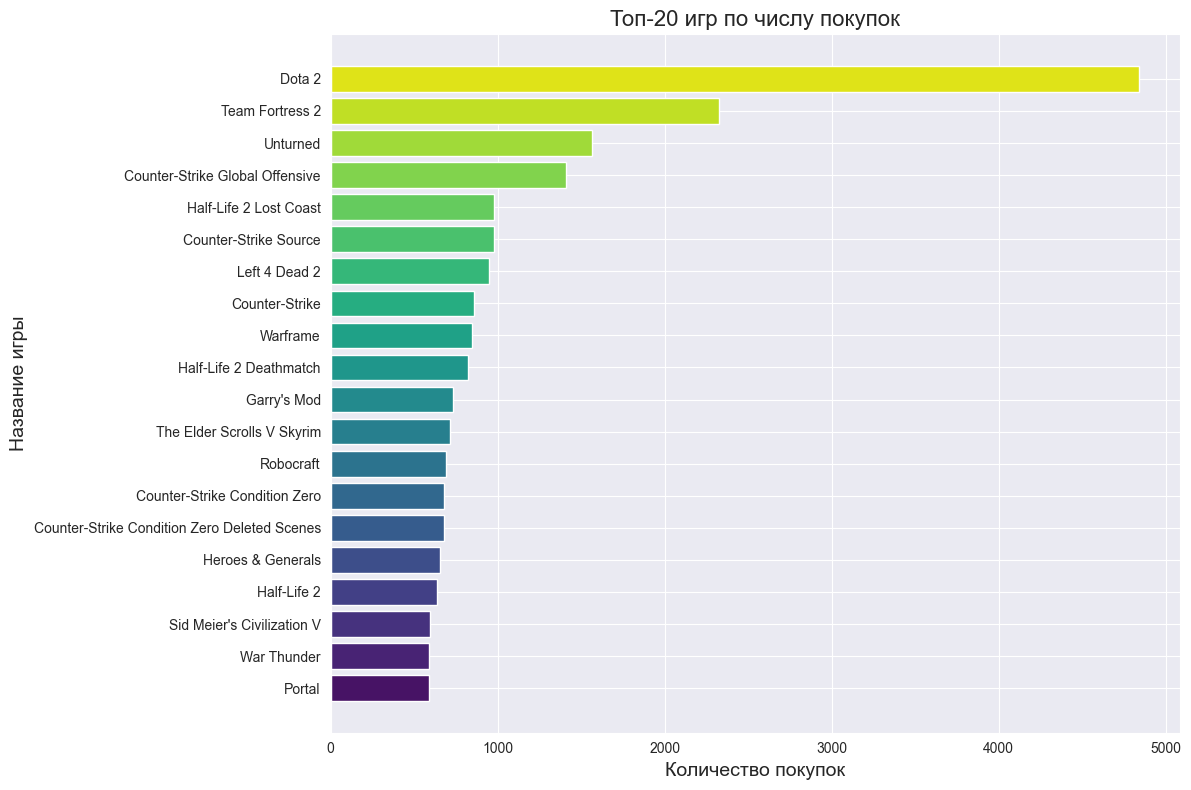

In [10]:
purchases = df[df['behavior_name'] == 'purchase']
purchase_counts = purchases['game_title'].value_counts().head(20).sort_values()
colors = sns.color_palette("viridis", len(purchase_counts))

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.barh(purchase_counts.index, purchase_counts.values, color=colors)
plt.title('Топ-20 игр по числу покупок', fontsize=16)
plt.xlabel('Количество покупок', fontsize=14)
plt.ylabel('Название игры', fontsize=14)
plt.tight_layout()
plt.show()


Видим, что Dota 2 в одиночку с большим отрывом побеждаем многие игры. Однако стоит отметить, что такие игры как Half-Life 2 охотно покупают и с дополнениями. Интересно будет посмотреть аналитику по сериям игр

2. Популярность по количеству проведенных часов

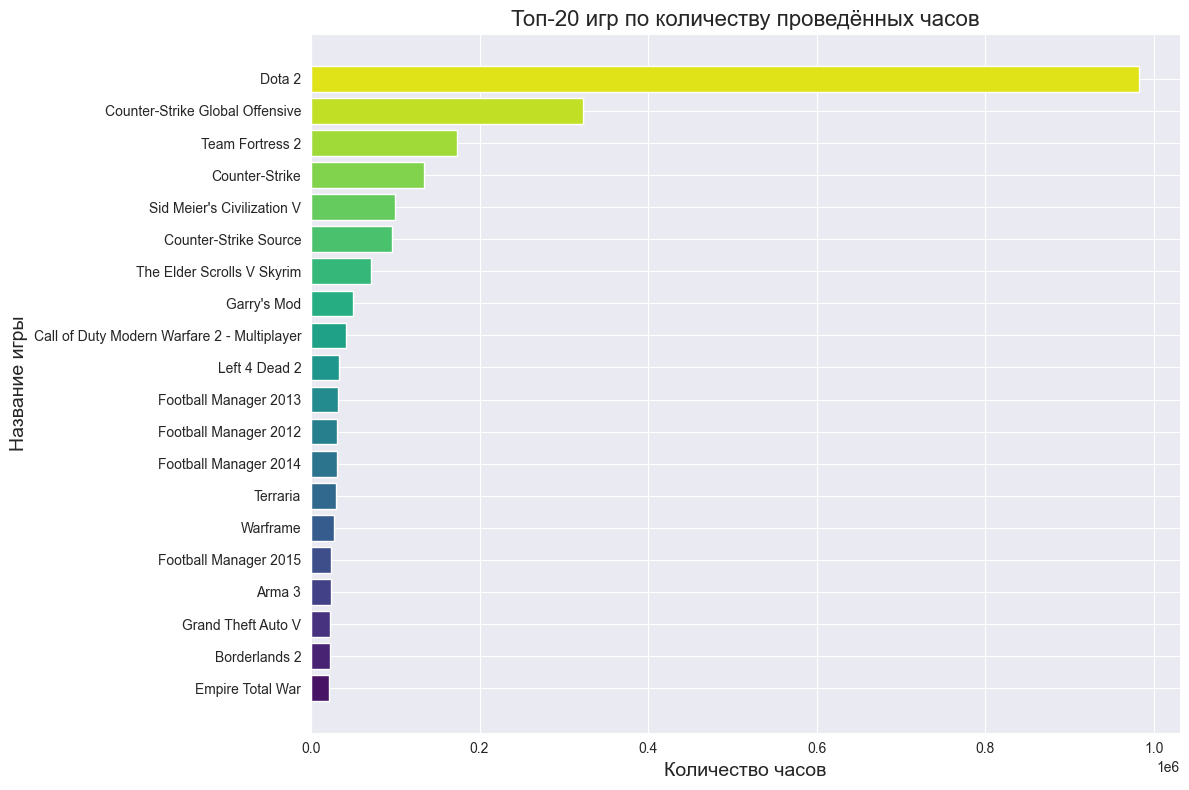

In [11]:
plays = df[df['behavior_name'] == 'play']
play_hours = plays.groupby('game_title')['value'].sum()
top_20_play_hours = play_hours.sort_values(ascending=False).head(20).sort_values()

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.barh(top_20_play_hours.index, top_20_play_hours.values, color=colors)
plt.title('Топ-20 игр по количеству проведённых часов', fontsize=16)
plt.xlabel('Количество часов', fontsize=14)
plt.ylabel('Название игры', fontsize=14)
plt.tight_layout()
plt.show()


Видим, что Dota 2 все еще в топе, однако наверх поднимается серия игр Football Manager, например. Значит, хоть эта игра и покупается нечасто, но она хорошо удерживает пользователя.

----
### Данные в разрезе пользователей. 
Посмотрим, сколько в среднем игр у одного пользователя

Ключевые квантили количества уникальных игр на пользователя:
0.05     1.0
0.25     1.0
0.50     2.0
0.75     6.0
0.95    42.0
Name: game_title, dtype: float64


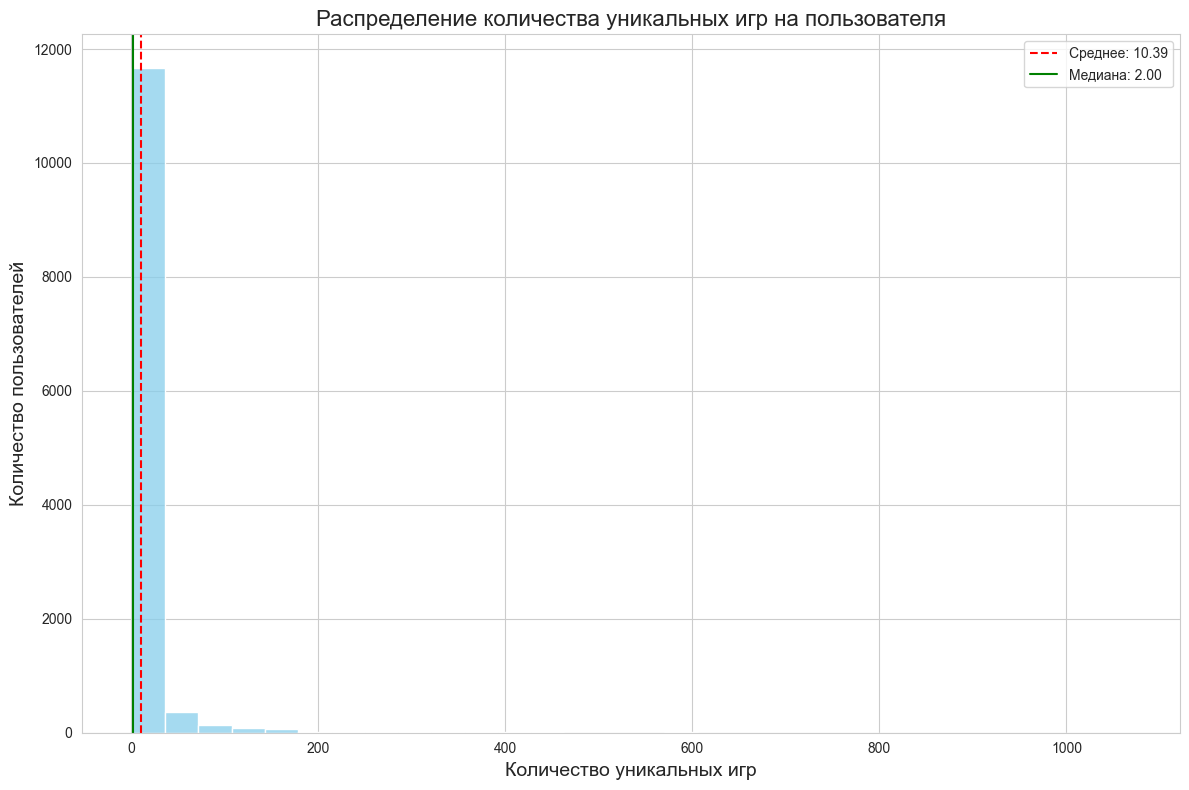

In [12]:
user_game_counts = df.groupby('user_id')['game_title'].nunique()
mean_games = user_game_counts.mean()
median_games = user_game_counts.median()

quantiles = user_game_counts.quantile([0.05, 0.25, 0.5, 0.75, 0.95])
print("Ключевые квантили количества уникальных игр на пользователя:")
print(quantiles)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.histplot(user_game_counts, bins=30, kde=False, color='skyblue')
plt.axvline(mean_games, color='red', linestyle='--', label=f'Среднее: {mean_games:.2f}')
plt.axvline(median_games, color='green', linestyle='-', label=f'Медиана: {median_games:.2f}')

plt.title('Распределение количества уникальных игр на пользователя', fontsize=16)
plt.xlabel('Количество уникальных игр', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


Видим гамма-распределение с очень тяжелым длинным хвостом. Половина пользователей покупает не более двух игр

Построим аналогичный график с общим количеством часов на одного пользователя

Ключевые квантили суммы часов игры на пользователя:
0.05       0.300
0.25       2.300
0.50      19.500
0.75     198.975
0.95    1637.755
Name: value, dtype: float64


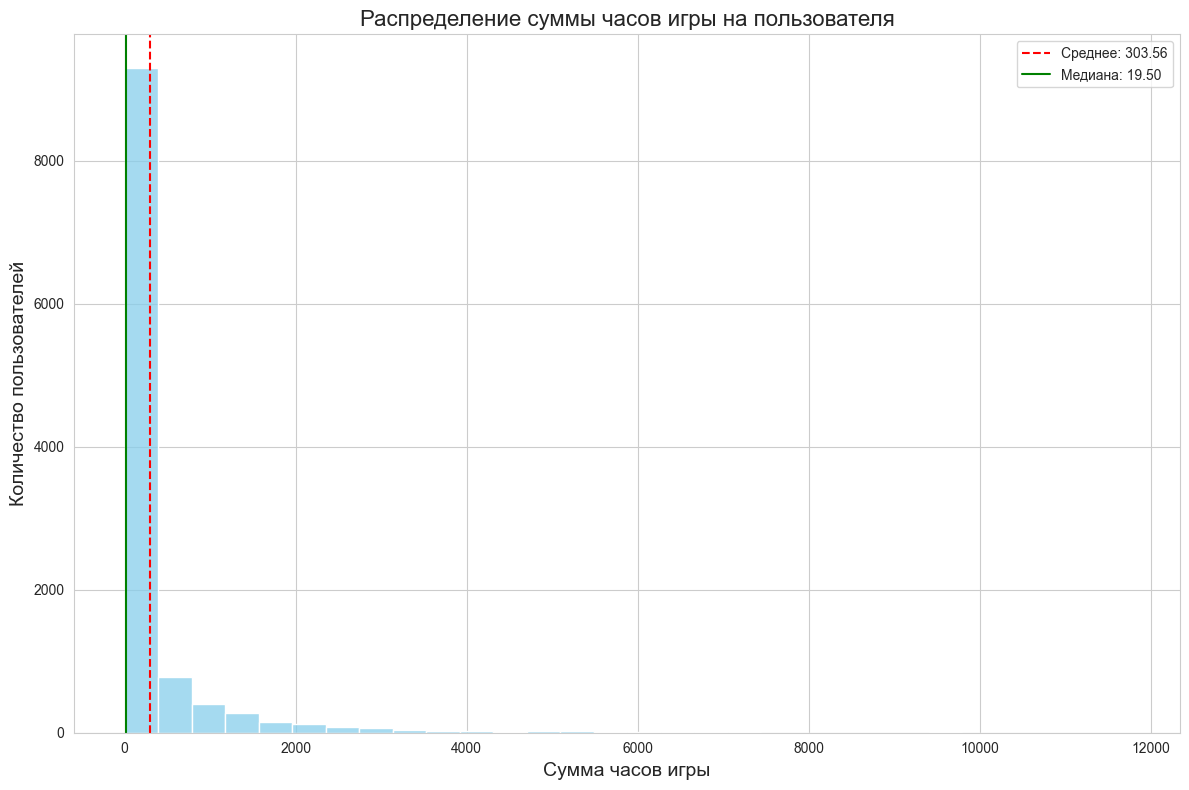

In [13]:
user_play_hours = plays.groupby('user_id')['value'].sum()
mean_hours = user_play_hours.mean()
median_hours = user_play_hours.median()
quantiles_hours = user_play_hours.quantile([0.05, 0.25, 0.5, 0.75, 0.95])

print("Ключевые квантили суммы часов игры на пользователя:")
print(quantiles_hours)

plt.figure(figsize=(12, 8))
sns.histplot(user_play_hours, bins=30, kde=False, color='skyblue')
plt.axvline(mean_hours, color='red', linestyle='--', label=f'Среднее: {mean_hours:.2f}')
plt.axvline(median_hours, color='green', linestyle='-', label=f'Медиана: {median_hours:.2f}')
plt.title('Распределение суммы часов игры на пользователя', fontsize=16)
plt.xlabel('Сумма часов игры', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


Следующий график - среднее число часов от одного пользователя на игру

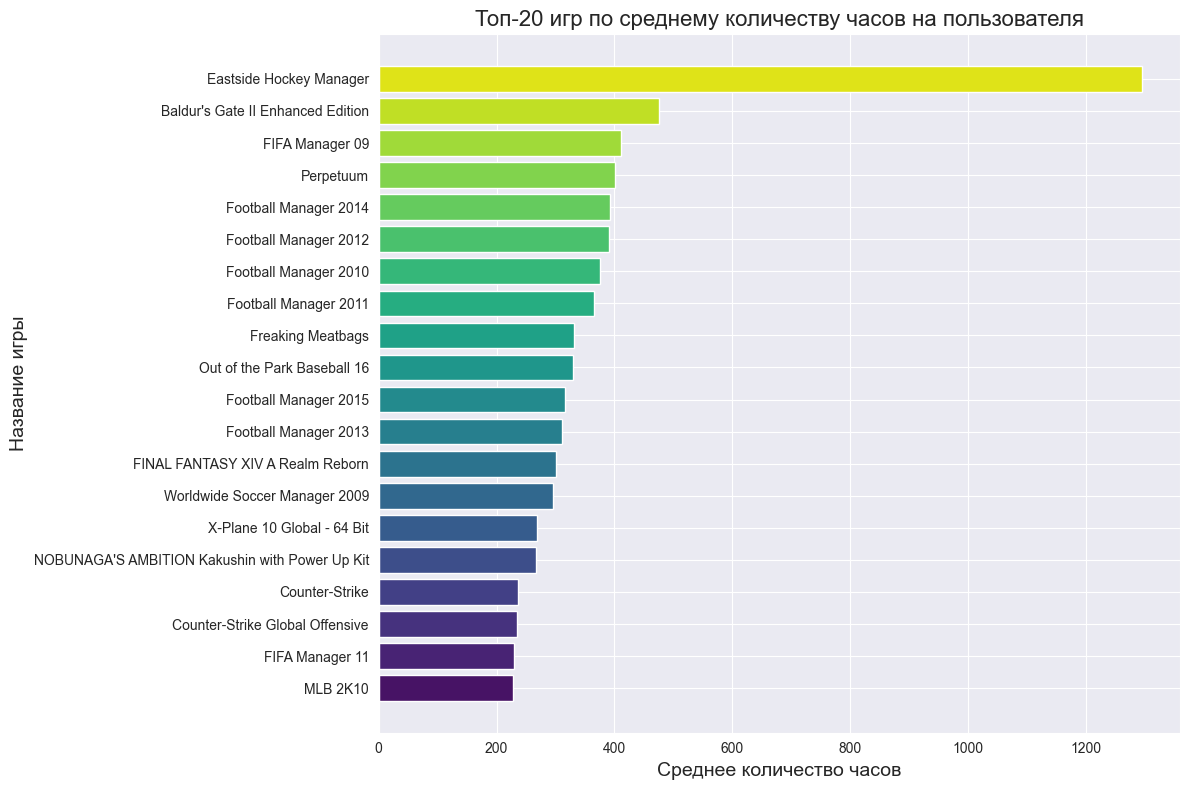

In [14]:
user_hours = plays.groupby(['game_title', 'user_id'])['value'].sum().reset_index()
avg_hours = user_hours.groupby('game_title')['value'].mean()
top20_avg_hours = avg_hours.sort_values(ascending=False).head(20).sort_values()

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.barh(top20_avg_hours.index, top20_avg_hours.values, color=colors)
plt.title('Топ-20 игр по среднему количеству часов на пользователя', fontsize=16)
plt.xlabel('Среднее количество часов', fontsize=14)
plt.ylabel('Название игры', fontsize=14)
plt.tight_layout()
plt.show()


На самом деле, график кажется нерепрезентативным. 

Здесь представлены нишевые игры с небольшим числом самых заинтересованных пользователей

In [15]:
df[df['game_title'] == 'Eastside Hockey Manager'] # один герой вывел игру в топ :)


,user_id,game_title,behavior_name,value
194333,213854339,Eastside Hockey Manager,purchase,1.0
194334,213854339,Eastside Hockey Manager,play,1295.0


-------

### Анализ дополнений. Распределение игр по сериям

Дополнения вплетаются в названия игры, но где-то это делается через двоеточие, где-то через тире, а где-то и просто добавляются новые слова. Попробуем разделить игры по их сериям

In [16]:
df[df['game_title'].str.contains('-')]
# в такой подход, например, не попадет Half Life 2 и Half Life 2 Lost Coast

,user_id,game_title,behavior_name,value
27,151603712,Dragon Age Origins - Ultimate Edition,purchase,1.0
28,151603712,Dragon Age Origins - Ultimate Edition,play,1.3
29,151603712,Fallout 3 - Game of the Year Edition,purchase,1.0
30,151603712,Fallout 3 - Game of the Year Edition,play,0.8
61,151603712,The Banner Saga - Mod Content,purchase,1.0
...,...,...,...,...
199956,176449171,Counter-Strike Condition Zero,purchase,1.0
199957,176449171,Counter-Strike Condition Zero Deleted Scenes,purchase,1.0
199958,176449171,Counter-Strike Source,purchase,1.0
199963,221315846,Tom Clancy's Ghost Recon Phantoms - EU,purchase,1.0


Поэтому для решения этой проблемы я использую подход TF-IDF + Аггломеративная кластеризация по следующим причинам:

* Простой метод (подходящий для нашего случая)
* TF-IDF учитывает "важность" (вес) слов, выделяя уникальные и информативные слова для игры
* Аггломеративная кластеризация позволяет автоматически выделять группы на основе заданного расстояния

In [17]:
titles = [title for title in df['game_title'].unique() if isinstance(title, str) and title.strip() != ""]

# Используем TF-IDF без стоп-слов и с изменённым token_pattern для коротких названий
vectorizer = TfidfVectorizer(stop_words=None, token_pattern=r'(?u)\b\w+\b')
X = vectorizer.fit_transform(titles)

print("Размерность TF-IDF матрицы:", X.shape)
print("Примеры токенов из словаря:", list(vectorizer.vocabulary_.keys())[:10])

Размерность TF-IDF матрицы: (5155, 5068)
Примеры токенов из словаря: ['the', 'elder', 'scrolls', 'v', 'skyrim', 'fallout', '4', 'spore', 'new', 'vegas']


Кластеризуем названия. Здесь n_clusters=None и distance_threshold=0.5 позволяют кластеризатору определить число кластеров автоматически. Порог можно подбирать экспериментально.

Я пробовала ставить от 0.3 до 0.7, но остановилась на медиане - так получилось собрать многие дополнения в одни кластеры без "FP"-ошибок

In [18]:
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5, 
    metric='cosine',  
    linkage='average'
)

labels = clustering.fit_predict(X.toarray())

grouped_titles = pd.DataFrame({'game_title': titles, 'cluster': labels})
print(grouped_titles.sort_values(by='cluster'))

df = df.merge(grouped_titles, on='game_title', how='left')

                             game_title  cluster
3469                  TrackMania Valley        0
3590                  TrackMania United        0
1074               Need for Speed SHIFT        1
250          Need for Speed Hot Pursuit        1
3444                 NEED FOR MADNESS ?        1
...                                 ...      ...
1329  Desperados - Wanted Dead or Alive     3508
3701                             TOXIKK     3509
1898                    Esenthel Engine     3510
626                Half-Life Blue Shift     3511
1834                           Redshirt     3512

[5155 rows x 2 columns]


Здесь можно посмотреть все кластеры, если интересно

In [19]:
for i in range(df['cluster'].max()):
    print(f"Серия игр: {i}")
    print(df[df['cluster'] == i]['game_title'].unique())
    print("-----")

Серия игр: 0
['TrackMania Valley' 'TrackMania United']
-----
Серия игр: 1
['Need for Speed Hot Pursuit' 'Need for Speed Undercover'
 'Need for Speed SHIFT' 'NEED FOR MADNESS ?']
-----
Серия игр: 2
['A Walk in the Dark' 'Year Walk']
-----
Серия игр: 3
['Dino D-Day' 'Iron Front  D-Day DLC']
-----
Серия игр: 4
['La Tale' 'La-Mulana']
-----
Серия игр: 5
['RPG Maker XP' 'RPG Maker 2000' 'RPG Maker Time Fantasy']
-----
Серия игр: 6
["Kung Fu Strike The Warrior's Rise" 'Rag Doll Kung Fu' 'Kings of Kung Fu']
-----
Серия игр: 7
['Ironclads Anglo Russian War 1866' 'Ironclads Chincha Islands War 1866']
-----
Серия игр: 8
['Silent Hunter III' 'Silent Hunter 5 Battle of the Atlantic']
-----
Серия игр: 9
['Devils Share' 'Devils & Demons']
-----
Серия игр: 10
['Horizon' 'Shattered Horizon' 'Shattered Horizon Arconauts'
 'Lost Horizon' 'Horizon Shift']
-----
Серия игр: 11
['Heli Heroes' 'Dustoff Heli Rescue']
-----
Серия игр: 12
['Fist of Jesus' 'FIST OF AWESOME']
-----
Серия игр: 13
['Majesty 2 Colle

В процессе просмотра можно заметить несколько продуктов, не относящихся к играм. Их я разберу в пункте 4 про очистку данных.

Ниже выведены топ-20 самых больших кластеров

In [20]:
unique_games_per_cluster = df.groupby('cluster')['game_title'].nunique()
top_clusters = unique_games_per_cluster.sort_values(ascending=False).head(20).index

for cluster in top_clusters:
    print(f"Серия игр: {cluster}")
    print(df[df['cluster'] == cluster]['game_title'].unique())
    print("-----")


Серия игр: 162
["Tom Clancy's Ghost Recon Phantoms - NA"
 "Tom Clancy's Ghost Recon Phantoms - EU"
 "Tom Clancy's Ghost Recon Advanced Warfighter 2"
 "Tom Clancy's Ghost Recon Phantoms - NA Recon Starter Pack"
 "Tom Clancy's Ghost Recon Phantoms - EU Support Starter Pack"
 "Tom Clancy's Ghost Recon Advanced Warfighter"
 "Tom Clancy's Ghost Recon Phantoms - EU The Thrill of the Surprise"
 "Tom Clancy's Ghost Recon Future Soldier"
 "Tom Clancy's Ghost Recon Phantoms - EU Assault Starter Pack"
 "Tom Clancy's Ghost Recon Phantoms - EU Looks and Power (Assault)"
 "Tom Clancy's Ghost Recon Phantoms - EU Looks and Power (Recon)"
 "Tom Clancy's Ghost Recon Phantoms - EU Looks and Power (Support)"
 "Tom Clancy's Ghost Recon Phantoms - EU Recon Starter Pack"
 "Tom Clancy's Ghost Recon Phantoms - EU Substance with Style pack (Assault)"
 "Tom Clancy's Ghost Recon Phantoms - EU Substance with Style pack (Recon)"
 "Tom Clancy's Ghost Recon Phantoms - EU Substance with Style pack (Support)"
 "Tom Cla

Этот признак поможет проверить гипотезу о том, что проще рекомендовать пользователю "похожие игры" из одной серии.

# 3. Задачи, которые можно было бы решать с этим набором данных

Подведем небольшой итог нашим исследованиям:

*Большинство пользователей пробует ограниченное число игр, в то время как небольшая группа активно исследует и играет в гораздо большее количество игр. Это типичный признак длинного правого хвоста, где редкие, но экстремальные значения (очень активные пользователи) заметно смещают распределение.*


Можно выделить две группы:

1. Большинство (массовый сегмент): Пользователи, ограничивающиеся сравнительно небольшим числом игр.
2. Лояльные/задачные пользователи: Небольшая часть, играющая во множество различных игр, что отражается в хвосте распределения.


Такое распределение позволяет сфокусироваться на двух типах пользователей:

1. Для массовой аудитории можно разрабатывать стратегии удержания и повышения вовлеченности, предлагая персонализированные рекомендации для тех, кто играет в ограниченный набор игр.
2. Для активных пользователей можно предложить эксклюзивный контент, бета-доступ к новым играм или программы лояльности, учитывая, что они готовы исследовать и пробовать больше игр.


Таким образом, в этом наборе данных можно строить модели **рекомендательных систем**

## 4. Обработка данных. Описание проблем

Суммаризуем описанные выше проблемы:

* Странная ситуация, когда игрок играл в игру, но не было факта совершения ее покупки.

* Еще дополнение могли покупать чаще основной игры, хотя играть чисто в дополнение невозможно. Возможно это связано с тем что при покупке дополнения можно было бы автоматически докупить и игру (так называемый набор, но информации об этом нет)

* Нет никакой явной связи игр. В датасете нет информации по этому поводу и невозможно одозначно точно отделить игры по сериям и дополнениям

* Мы не можем проанализировать, в какой момент пользователь склоняется к покупке дополнения. Сколько часов в среднем требуется пользователю для покупки DLC? А для покупки новой игры? Сколько в среднем длится одна игровая сессия у пользователя? Как меняется динамика игры? 

Теперь проверим данные на пропуски и соответствие типов

In [21]:
df.isna().sum() # ok

user_id          0
game_title       0
behavior_name    0
value            0
cluster          0
dtype: int64

In [22]:
df.info() # ok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        199999 non-null  int64  
 1   game_title     199999 non-null  object 
 2   behavior_name  199999 non-null  object 
 3   value          199999 non-null  float64
 4   cluster        199999 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [23]:
(df['value'] == 0).sum() # ok 

0

Во время анализа сгенерированных кластеров заметила ряд игр, содержащих "Profile". Это не игра, а просто продукт. В нем нельзя провести время или посчитать часы. Поэтому уберу его из датасета

In [24]:
print(len(df[df['game_title'].str.contains('Profiles')]))

df[df['game_title'].str.contains('Profiles')]['game_title'].unique()

165


array(['CSGO Player Profiles', 'CSGO Player Profiles - Device',
       'CSGO Player Profiles - Edward', 'CSGO Player Profiles - Fallen',
       'CSGO Player Profiles - Get_Right',
       'CSGO Player Profiles - KennyS',
       'CSGO Player Profiles - Markeloff',
       'CSGO Player Profiles - N0thing',
       'CSGO Player Profiles - Olofmeister', 'CSGO Player Profiles - Taz',
       'Dota 2 - The International 2015 - Player Profiles',
       'TI5 - Player Profiles Cloud9 - NoTail',
       'TI5 - Player Profiles Complexity - zfreek',
       'TI5 - Player Profiles EG - Suma1L',
       'TI5 - Player Profiles EHOME - ROTK',
       'TI5 - Player Profiles Empire - Alohadance',
       'TI5 - Player Profiles Fnatic - Kecik-Imba',
       'TI5 - Player Profiles Invictus Gaming - Ferrari',
       'TI5 - Player Profiles LGD - Xiao8',
       'TI5 - Player Profiles MVPHot6 - HEEN',
       'TI5 - Player Profiles NAVI - XBOCT',
       'TI5 - Player Profiles Newbee - Mu',
       'TI5 - Player Profiles 

In [25]:
df = df[~df['game_title'].str.contains('Profiles')]

В остальном данные готовы для рекомендательной системы

## 5. Построение модели

Сначала мы рассмотрим модель по всем уникальным играм, не объединяя их в одну для серии. Будем смотреть по часам, проведенным в игре. Попробуем предсказать время, проведенное пользователем в игре


Алгоритм SVD разлагает матрицу оценок R (где строки — пользователи, столбцы — игры) на три матрицы:

$U$ – латентные факторы пользователей,

$\Sigma$ – диагональная матрица с сингулярными значениями,

$V^T$ – латентные факторы объектов (игр).

Это позволяет уменьшить размерность исходной разреженной матрицы и выявить скрытые зависимости между пользователями и играми. В результате мы можем предсказывать, насколько пользователю понравится та или иная игра, даже если прямые данные для этой пары отсутствуют.

In [26]:
rating_df = df[df['behavior_name'] == 'play'][['user_id', 'game_title', 'value']].copy()

rating_df['user_id'] = rating_df['user_id'].astype(str)
rating_df['game_title'] = rating_df['game_title'].astype(str)

Класс Reader из библиотеки scikit-surprise отвечает за интерпретацию входных данных. Он определяет, какие столбцы содержат идентификаторы пользователей, объектов и рейтинги, а также задаёт диапазон значений рейтингов с помощью параметра rating_scale.

Если диапазон задан завышенно (например, от 0 до 1000 вместо 10 до 300), то абсолютные ошибки, такие как RMSE и MAE, будут больше, даже если относительное качество предсказаний остаётся тем же. Это связано с тем, что метрики рассчитываются в тех же единицах, что и оценки.

In [27]:
reader = Reader(rating_scale=(10, 100))

data = Dataset.load_from_df(rating_df, reader)

In [28]:
# Разбиваем данные на обучающую и тестовую выборки (80/20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD(random_state=42)

# Обучаем модель
algo.fit(trainset)

In [29]:
predictions = algo.test(testset)

rmse_value = accuracy.rmse(predictions)
mae_value = accuracy.mae(predictions)


RMSE: 240.5031
MAE:  113.2012


Видим, что отклонение в часах очень большое

Теперь попробуем объединять серию игр в одну игру. И вновь построим подобную рекомендательную систему

In [ ]:
# Группируем по пользователям и кластерам:
df_user_cluster = plays.groupby(['user_id', 'cluster']).agg({
    'game_title': 'first',  # выбираем первое название игры в кластере
    'value': 'sum'          # суммируем часы игры для данного пользователя по кластеру
}).reset_index()

rating_df = df_user_cluster[['user_id', 'game_title', 'value']].copy()

rating_df['user_id'] = rating_df['user_id'].astype(str)
rating_df['game_title'] = rating_df['game_title'].astype(str)


In [ ]:
reader = Reader(rating_scale=(10, 100))

data = Dataset.load_from_df(rating_df, reader)

In [55]:
# Разбиваем данные на обучающую и тестовую выборки (80/20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD(random_state=42)

# Обучаем модель
algo.fit(trainset)

In [56]:
predictions = algo.test(testset)

rmse_value = accuracy.rmse(predictions)
mae_value = accuracy.mae(predictions)


RMSE: 252.2431
MAE:  73.9159


Получилось немного улучшить результат, однако он все еще далек от идеала. Попробуем упростить постановку задачи: предсказывать, будет ли пользователь играть в предложенную игру (бинарная классификация)

Чтобы оценить, что пользователю "нравится" игра, будем считать, что для этого необходимо провести в ней от 15ч

In [ ]:
play_df = df[df['behavior_name'] == 'play'].copy()

# Создаём бинарную метку: 1 если часов >= 15, иначе 0
play_df['target'] = (play_df['value'] >= 15).astype(int)
play_df['user_id'] = play_df['user_id'].astype(str)
play_df['game_title'] = play_df['game_title'].astype(str)

data_df = play_df[['user_id', 'game_title', 'target']]

In [59]:
reader = Reader(rating_scale=(0, 1))

# Загружаем данные в формат Surprise
data = Dataset.load_from_df(data_df, reader)

In [60]:
# Разбиваем данные на обучающую и тестовую выборки (80/20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD(random_state=42)

# Обучаем модель
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)

# Извлекаем истинные и предсказанные значения
y_true = np.array([pred.r_ui for pred in predictions])
y_pred = np.array([1 if pred.est >= 0.5 else 0 for pred in predictions])

# Вычисляем метрики
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, [pred.est for pred in predictions])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.7488296212228684
Precision: 0.6127450980392157
Recall: 0.3664793549963352
F1 Score: 0.4586454670539673
ROC AUC: 0.754542933761558
Confusion Matrix:
 [[9057  948]
 [2593 1500]]


Теперь попробуем провести такую же задачу для серий игр (кластеров)

In [ ]:
play_df = df_user_cluster.copy()

# Создаём бинарную метку: 1 если часов >= 15, иначе 0
play_df['target'] = (play_df['value'] >= 15).astype(int)
play_df['user_id'] = play_df['user_id'].astype(str)
play_df['game_title'] = play_df['game_title'].astype(str)

data_df = play_df[['user_id', 'game_title', 'target']]

In [64]:
reader = Reader(rating_scale=(0, 1))

# Загружаем данные в формат Surprise
data = Dataset.load_from_df(data_df, reader)

In [65]:
# Разбиваем данные на обучающую и тестовую выборки (80/20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD(random_state=42)

# Обучаем модель
algo.fit(trainset)

In [66]:
predictions = algo.test(testset)

# Извлекаем истинные и предсказанные значения
y_true = np.array([pred.r_ui for pred in predictions])
y_pred = np.array([1 if pred.est >= 0.5 else 0 for pred in predictions])

# Вычисляем метрики
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, [pred.est for pred in predictions])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.7521038143924499
Precision: 0.638947815019092
Recall: 0.3955870764381403
F1 Score: 0.48864373783257625
ROC AUC: 0.7636122968006493
Confusion Matrix:
 [[8057  851]
 [2301 1506]]


Как мы видим, метрики удалось немного улучшить нашим преобразованием

# 6. Бизнес-задача и бизнес-метрики

Выше уже описывались примеры бизнес-задач, которые можно было бы решать с помощью этих данных (п.3). 

С точки зрения используемой модели, мы могли бы решать бизнес-задачу рекомендации пользователям игр на платформе Steam. Думаю, что в таком случае в качестве бизнес-метрики можно было бы использовать "точность" или Precision - ведь каждое TP попадание приносит прибыль платформе.
